This notebook created for educational purposes. I am going to try different classification models with precise hyperparameters tuning for prediction of cardiovascular diseases presence.

# Imports and data processing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import optuna
import xgboost as xgb
import joblib

In [3]:
import warnings
warnings.filterwarnings('ignore')

I'll do some quick preprocessing of data to get rid of outliers in weight, height and arterial pressure.

In [4]:
df = pd.read_csv('cardio_train.csv', delimiter=';')

df['gender'] = df['gender'].replace(2,0)
quantitatives = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categoricals = ['gender','cholesterol','gluc','smoke','alco','active']
for i in quantitatives[1:]:
    df = df.drop(df[(df[i] > df[i].quantile(0.999)) | (df[i] < df[i].quantile(0.001))].index)
df = df.drop(df[df['ap_lo'] >= df['ap_hi']].index)


In [5]:
X = df[df.columns[1:-1]]
y = df['cardio']

In [6]:
y.shape, y.sum()

((68419,), 33836)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68419 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68419 non-null  int64  
 1   gender       68419 non-null  int64  
 2   height       68419 non-null  int64  
 3   weight       68419 non-null  float64
 4   ap_hi        68419 non-null  int64  
 5   ap_lo        68419 non-null  int64  
 6   cholesterol  68419 non-null  int64  
 7   gluc         68419 non-null  int64  
 8   smoke        68419 non-null  int64  
 9   alco         68419 non-null  int64  
 10  active       68419 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 6.3 MB


The dataset is quite large, and somewhat balanced. There are no null-values. We can plot 

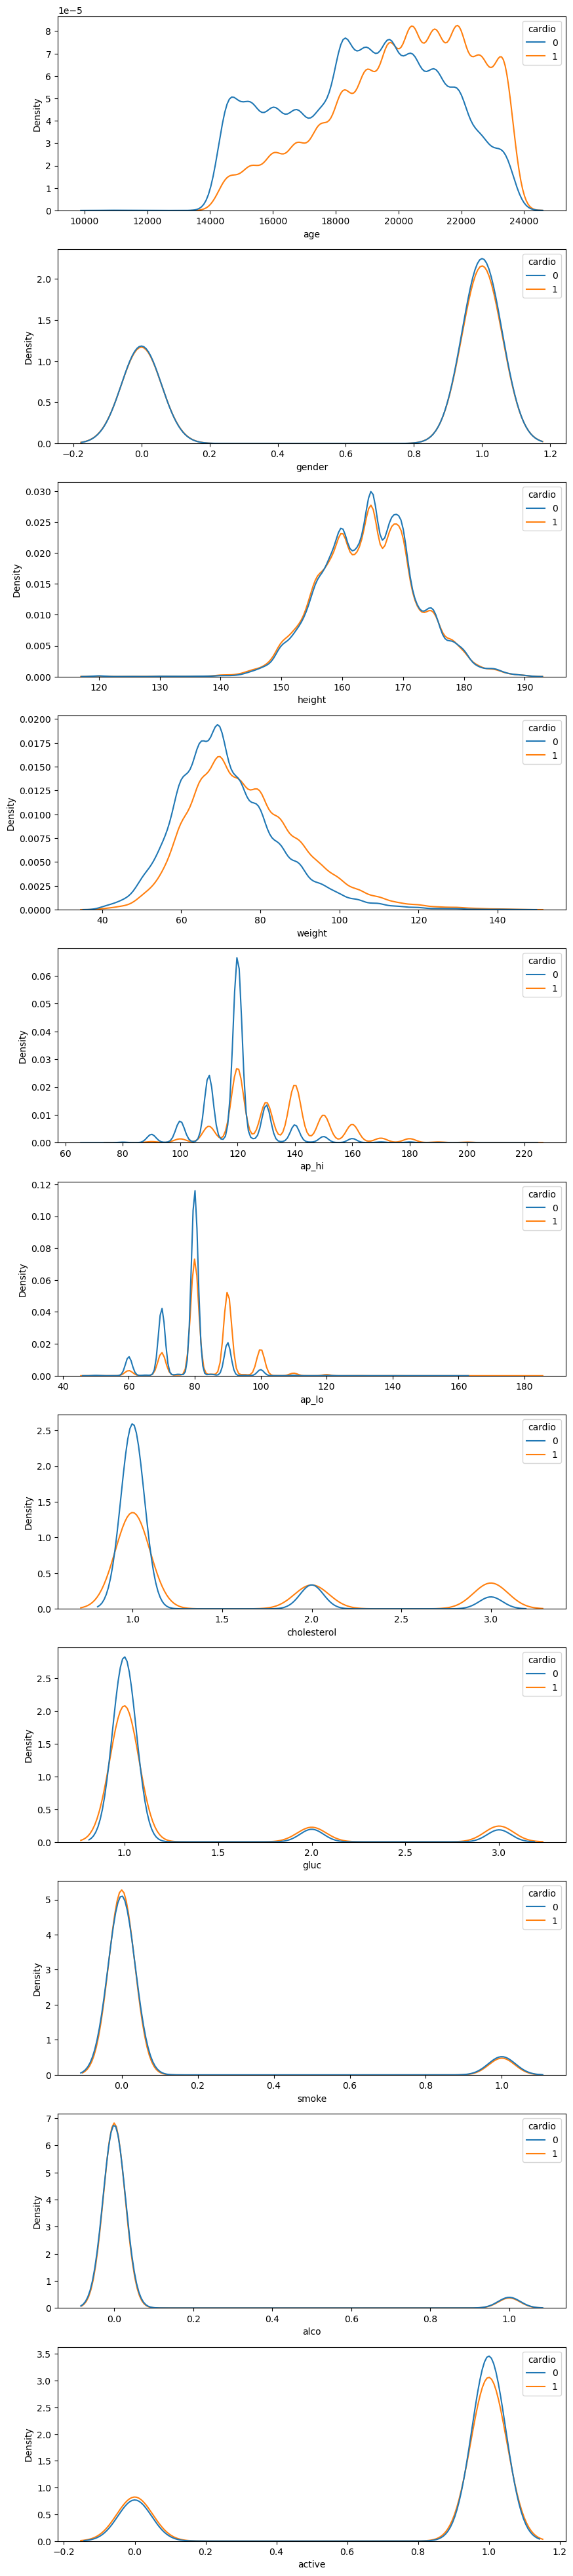

In [9]:
axes = plt.subplots(figsize=(10, 50), nrows=11)[1]
for i, label in enumerate(X.columns):
    sns.kdeplot(data=X, x=label, ax=axes[i], hue=y)

It seems to me that for most patients the data for arterial pressure was rounded up. Age was presumably transformed from years to days.

In [8]:
X['ap_lo'].value_counts()

ap_lo
80     34653
90     14216
70     10175
100     4054
60      2702
       ...  
107        1
122        1
125        1
54         1
111        1
Name: count, Length: 80, dtype: int64

In [9]:
X['age'] = X['age'] // 365
X['ap_lo'] = X['ap_lo'].round(-1)
X['ap_hi'] = X['ap_hi'].round(-1)

In [10]:
X['ap_dif'] = X['ap_hi'] - X['ap_lo']

In [11]:
X['ap_dif'].value_counts()

ap_dif
40     35283
50     14807
60      7337
30      5767
70      2520
80      1041
20       997
90       382
100      144
10        80
110       42
120       11
130        6
0          1
140        1
Name: count, dtype: int64

<Axes: >

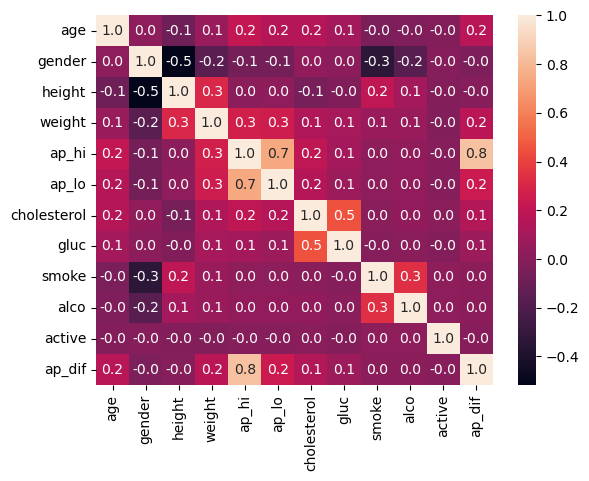

In [12]:
sns.heatmap(data=X.corr(), annot=True, fmt='.1f')

I can note interesting thing from this correlation matrix: higher people seems to smoke more.

Split the data for test and train parts, and scale the quantitatives

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [14]:
quantitatives = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'ap_dif']
preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), quantitatives)], remainder='passthrough')
preprocessor.set_output(transform='pandas')
X_scaled_train = preprocessor.fit_transform(X_train)
X_scaled_test = preprocessor.fit_transform(X_test)

# XGBoost

In [45]:
def objective(trial):
    cv_kfold = KFold(n_splits=5, shuffle=True)
    # initiate and fit the model
    model = xgb.XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        max_depth=trial.suggest_int('max_depth', 5, 15),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 0.1, 1),
        subsample=trial.suggest_float('subsample', 0.5, 1),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 0, 1),
        n_jobs=-1
        )
    scores = cross_val_score(model, X_scaled_train, y_train, scoring='roc_auc', cv=cv_kfold, n_jobs=-1)

    return scores.mean() # An objective value linked with the Trial object.

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.
joblib.dump(study, "/kaggle/working/study_xgb.pkl") #save to file

[I 2024-04-06 18:43:51,412] A new study created in memory with name: no-name-e71cf458-7b24-4f5d-ac3b-68e13489932d
[I 2024-04-06 18:43:55,988] Trial 0 finished with value: 0.7986562881831691 and parameters: {'n_estimators': 414, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 0.9381012329274537, 'subsample': 0.9728402292224139, 'colsample_bytree': 0.7485230871400896, 'learning_rate': 0.14582952902521576, 'reg_alpha': 0.24590226994494802, 'reg_lambda': 0.5169242153247855}. Best is trial 0 with value: 0.7986562881831691.
[I 2024-04-06 18:44:02,659] Trial 1 finished with value: 0.7897331548089592 and parameters: {'n_estimators': 654, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.48131178254071705, 'subsample': 0.6959640848602686, 'colsample_bytree': 0.5679651667391364, 'learning_rate': 0.03961105191962553, 'reg_alpha': 0.7740819598975224, 'reg_lambda': 0.05066169731776604}. Best is trial 0 with value: 0.7986562881831691.
[I 2024-04-06 18:44:11,627] Trial 2 finished with value: 0.7649

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/study.pkl'

In [17]:
#study = joblib.load("study_xgb.pkl") #uncomment to load file
#study.best_params
#params = pd.Series(study.best_params).to_frame().T
#params

In [18]:
# optuna.visualization.plot_contour(study, params= ['n_estimators', 'max_depth'])

In [46]:
study.best_params

{'n_estimators': 247,
 'max_depth': 5,
 'min_child_weight': 2,
 'gamma': 0.7495285850247295,
 'subsample': 0.7734939641779977,
 'colsample_bytree': 0.5482563922066731,
 'learning_rate': 0.045556246904069994,
 'reg_alpha': 0.9885806119347939,
 'reg_lambda': 0.9535517775371495}

In [47]:
xgb_model = xgb.XGBClassifier(**study.best_params, n_jobs=-1)
xgb_model.fit(X_scaled_train, y_train)
xgb_results = model.predict(X_scaled_test)
xgb_proba = model.predict_proba(X_scaled_test)

In [48]:
roc_auc_score(y_test, xgb_proba[:,1]), accuracy_score(y_test, xgb_results), precision_score(y_test, xgb_results)

(0.7992907756035516, 0.7315404852382345, 0.7821392091055013)

Text(0, 0.5, 'TPR')

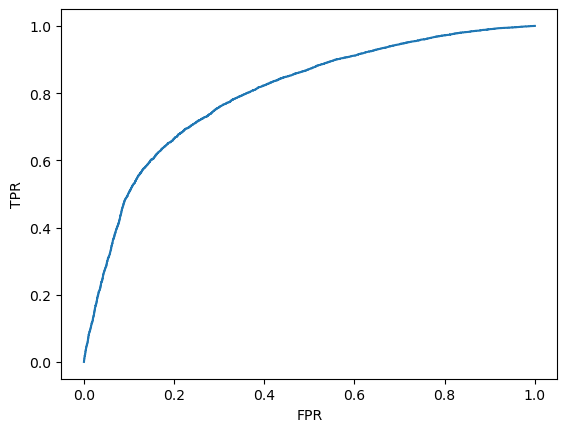

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

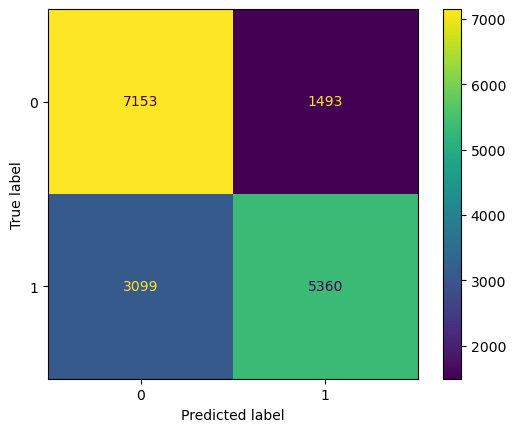

In [50]:
ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_results)).plot()

# Catboost

In [58]:
import catboost as cb

In [25]:
def objective(trial: optuna.Trial) -> float:
    cv_kfold = KFold(n_splits=3, shuffle=True)
    
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    scores = cross_val_score(gbm, X_scaled_train, y_train, scoring='accuracy', cv=cv_kfold, n_jobs=-1)

    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
joblib.dump(study, "/kaggle/working/study_catboost.pkl") #save to file

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-04 18:13:12,263] A new study created in memory with name: no-name-f4a06751-b0d2-453e-89f7-e3f49512180f


0:	learn: 0.5922245	total: 79.6ms	remaining: 1m 19s
1:	learn: 0.5922245	total: 100ms	remaining: 50s
2:	learn: 0.5922245	total: 123ms	remaining: 41s
3:	learn: 0.5922245	total: 149ms	remaining: 37s
4:	learn: 0.5922245	total: 164ms	remaining: 32.7s
5:	learn: 0.5922245	total: 192ms	remaining: 31.8s
6:	learn: 0.6113417	total: 200ms	remaining: 28.3s
7:	learn: 0.6110494	total: 205ms	remaining: 25.5s
8:	learn: 0.6110494	total: 210ms	remaining: 23.1s
9:	learn: 0.6112833	total: 215ms	remaining: 21.3s
10:	learn: 0.6112833	total: 220ms	remaining: 19.8s
11:	learn: 0.6113417	total: 225ms	remaining: 18.5s
12:	learn: 0.6765566	total: 231ms	remaining: 17.6s
13:	learn: 0.6765566	total: 236ms	remaining: 16.7s
14:	learn: 0.6667641	total: 242ms	remaining: 15.9s
15:	learn: 0.6667641	total: 247ms	remaining: 15.2s
16:	learn: 0.6667641	total: 252ms	remaining: 14.6s
17:	learn: 0.6667641	total: 257ms	remaining: 14s
18:	learn: 0.6667641	total: 262ms	remaining: 13.5s
19:	learn: 0.6667641	total: 267ms	remaining: 13

[I 2024-04-04 18:13:25,854] Trial 0 finished with value: 0.7291577512360377 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.040707900568308704, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36990438705648737}. Best is trial 0 with value: 0.7291577512360377.


950:	learn: 0.7283835	total: 11.3s	remaining: 580ms
951:	learn: 0.7283835	total: 11.3s	remaining: 569ms
952:	learn: 0.7284127	total: 11.3s	remaining: 557ms
953:	learn: 0.7284127	total: 11.3s	remaining: 546ms
954:	learn: 0.7284127	total: 11.3s	remaining: 534ms
955:	learn: 0.7284127	total: 11.3s	remaining: 522ms
956:	learn: 0.7284127	total: 11.4s	remaining: 510ms
957:	learn: 0.7284127	total: 11.4s	remaining: 498ms
958:	learn: 0.7284127	total: 11.4s	remaining: 486ms
959:	learn: 0.7284712	total: 11.4s	remaining: 474ms
960:	learn: 0.7284712	total: 11.4s	remaining: 462ms
961:	learn: 0.7285881	total: 11.4s	remaining: 451ms
962:	learn: 0.7285881	total: 11.4s	remaining: 439ms
963:	learn: 0.7285881	total: 11.4s	remaining: 427ms
964:	learn: 0.7285881	total: 11.4s	remaining: 415ms
965:	learn: 0.7285881	total: 11.4s	remaining: 403ms
966:	learn: 0.7285881	total: 11.5s	remaining: 391ms
967:	learn: 0.7285881	total: 11.5s	remaining: 380ms
968:	learn: 0.7285881	total: 11.5s	remaining: 368ms
969:	learn: 

[I 2024-04-04 18:14:10,212] Trial 1 finished with value: 0.7276376606292851 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.02789150648954269, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16517049765191913}. Best is trial 0 with value: 0.7291577512360377.


900:	learn: 0.7280620	total: 39.5s	remaining: 4.34s
901:	learn: 0.7280620	total: 39.6s	remaining: 4.3s
902:	learn: 0.7281204	total: 39.6s	remaining: 4.26s
903:	learn: 0.7281204	total: 39.7s	remaining: 4.21s
904:	learn: 0.7281204	total: 39.7s	remaining: 4.17s
905:	learn: 0.7281204	total: 39.8s	remaining: 4.13s
906:	learn: 0.7281204	total: 39.8s	remaining: 4.08s
907:	learn: 0.7281204	total: 39.9s	remaining: 4.04s
908:	learn: 0.7281204	total: 39.9s	remaining: 3.99s
909:	learn: 0.7281204	total: 39.9s	remaining: 3.95s
910:	learn: 0.7280620	total: 40s	remaining: 3.9s
911:	learn: 0.7280620	total: 40s	remaining: 3.86s
912:	learn: 0.7281497	total: 40.1s	remaining: 3.82s
913:	learn: 0.7281497	total: 40.1s	remaining: 3.77s
914:	learn: 0.7280620	total: 40.1s	remaining: 3.73s
915:	learn: 0.7280620	total: 40.2s	remaining: 3.68s
916:	learn: 0.7281204	total: 40.2s	remaining: 3.64s
917:	learn: 0.7281204	total: 40.2s	remaining: 3.59s
918:	learn: 0.7281204	total: 40.3s	remaining: 3.55s
919:	learn: 0.7280

[I 2024-04-04 18:14:56,029] Trial 2 finished with value: 0.7282612349009634 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03550047927588929, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.15551090608893173}. Best is trial 0 with value: 0.7291577512360377.


850:	learn: 0.7317451	total: 38.2s	remaining: 6.69s
851:	learn: 0.7317451	total: 38.3s	remaining: 6.65s
852:	learn: 0.7317451	total: 38.3s	remaining: 6.61s
853:	learn: 0.7317451	total: 38.5s	remaining: 6.58s
854:	learn: 0.7318328	total: 38.5s	remaining: 6.53s
855:	learn: 0.7318328	total: 38.5s	remaining: 6.48s
856:	learn: 0.7318328	total: 38.6s	remaining: 6.44s
857:	learn: 0.7318328	total: 38.7s	remaining: 6.4s
858:	learn: 0.7318328	total: 38.7s	remaining: 6.36s
859:	learn: 0.7318328	total: 38.8s	remaining: 6.32s
860:	learn: 0.7318328	total: 38.9s	remaining: 6.28s
861:	learn: 0.7318328	total: 38.9s	remaining: 6.23s
862:	learn: 0.7315697	total: 39s	remaining: 6.19s
863:	learn: 0.7316282	total: 39s	remaining: 6.14s
864:	learn: 0.7315989	total: 39.1s	remaining: 6.1s
865:	learn: 0.7315989	total: 39.1s	remaining: 6.06s
866:	learn: 0.7315697	total: 39.2s	remaining: 6.02s
867:	learn: 0.7315697	total: 39.3s	remaining: 5.97s
868:	learn: 0.7315697	total: 39.3s	remaining: 5.93s
869:	learn: 0.7315

[I 2024-04-04 18:15:42,273] Trial 3 finished with value: 0.7276962016824676 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.021036429885647908, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.727048717943759}. Best is trial 0 with value: 0.7291577512360377.


850:	learn: 0.7250431	total: 38.4s	remaining: 6.72s
851:	learn: 0.7250431	total: 38.4s	remaining: 6.67s
852:	learn: 0.7250431	total: 38.5s	remaining: 6.64s
853:	learn: 0.7250431	total: 38.6s	remaining: 6.6s
854:	learn: 0.7250431	total: 38.7s	remaining: 6.56s
855:	learn: 0.7249847	total: 38.7s	remaining: 6.51s
856:	learn: 0.7249847	total: 38.8s	remaining: 6.47s
857:	learn: 0.7249847	total: 38.9s	remaining: 6.43s
858:	learn: 0.7251893	total: 38.9s	remaining: 6.38s
859:	learn: 0.7251893	total: 38.9s	remaining: 6.34s
860:	learn: 0.7251893	total: 39s	remaining: 6.29s
861:	learn: 0.7251016	total: 39.1s	remaining: 6.25s
862:	learn: 0.7251308	total: 39.1s	remaining: 6.21s
863:	learn: 0.7251308	total: 39.2s	remaining: 6.17s
864:	learn: 0.7251308	total: 39.2s	remaining: 6.12s
865:	learn: 0.7251308	total: 39.3s	remaining: 6.08s
866:	learn: 0.7251016	total: 39.4s	remaining: 6.04s
867:	learn: 0.7251016	total: 39.4s	remaining: 5.99s
868:	learn: 0.7250431	total: 39.5s	remaining: 5.95s
869:	learn: 0.7

[I 2024-04-04 18:15:56,370] Trial 4 finished with value: 0.7268387320851684 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0955196362931807, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.256661251175755}. Best is trial 0 with value: 0.7291577512360377.


849:	learn: 0.7251096	total: 11.7s	remaining: 2.06s
850:	learn: 0.7251388	total: 11.7s	remaining: 2.05s
851:	learn: 0.7251388	total: 11.7s	remaining: 2.04s
852:	learn: 0.7251388	total: 11.7s	remaining: 2.02s
853:	learn: 0.7251388	total: 11.8s	remaining: 2.01s
854:	learn: 0.7251388	total: 11.8s	remaining: 2s
855:	learn: 0.7250219	total: 11.8s	remaining: 1.99s
856:	learn: 0.7250512	total: 11.8s	remaining: 1.98s
857:	learn: 0.7250804	total: 11.9s	remaining: 1.96s
858:	learn: 0.7250804	total: 11.9s	remaining: 1.95s
859:	learn: 0.7251096	total: 11.9s	remaining: 1.94s
860:	learn: 0.7251096	total: 11.9s	remaining: 1.92s
861:	learn: 0.7250804	total: 11.9s	remaining: 1.91s
862:	learn: 0.7250804	total: 11.9s	remaining: 1.89s
863:	learn: 0.7250804	total: 11.9s	remaining: 1.88s
864:	learn: 0.7250804	total: 12s	remaining: 1.86s
865:	learn: 0.7250804	total: 12s	remaining: 1.85s
866:	learn: 0.7250804	total: 12s	remaining: 1.84s
867:	learn: 0.7250804	total: 12s	remaining: 1.82s
868:	learn: 0.7250804	t

[I 2024-04-04 18:16:42,547] Trial 5 finished with value: 0.726585370927944 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02112772422425559, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.390217138437981}. Best is trial 0 with value: 0.7291577512360377.


958:	learn: 0.7274694	total: 13.5s	remaining: 578ms
959:	learn: 0.7274694	total: 13.5s	remaining: 563ms
960:	learn: 0.7274694	total: 13.5s	remaining: 549ms
961:	learn: 0.7274694	total: 13.5s	remaining: 534ms
962:	learn: 0.7274109	total: 13.5s	remaining: 520ms
963:	learn: 0.7274109	total: 13.5s	remaining: 506ms
964:	learn: 0.7276740	total: 13.5s	remaining: 491ms
965:	learn: 0.7276740	total: 13.5s	remaining: 477ms
966:	learn: 0.7275863	total: 13.5s	remaining: 462ms
967:	learn: 0.7275571	total: 13.6s	remaining: 448ms
968:	learn: 0.7275571	total: 13.6s	remaining: 434ms
969:	learn: 0.7275571	total: 13.6s	remaining: 419ms
970:	learn: 0.7276155	total: 13.6s	remaining: 405ms
971:	learn: 0.7276155	total: 13.6s	remaining: 391ms
972:	learn: 0.7275571	total: 13.6s	remaining: 377ms
973:	learn: 0.7276155	total: 13.6s	remaining: 362ms
974:	learn: 0.7276155	total: 13.6s	remaining: 348ms
975:	learn: 0.7276448	total: 13.6s	remaining: 334ms
976:	learn: 0.7276448	total: 13.6s	remaining: 320ms
977:	learn: 

[I 2024-04-04 18:17:26,248] Trial 6 finished with value: 0.7241299086595049 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.014831223759002232, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2388875948670902}. Best is trial 0 with value: 0.7291577512360377.


859:	learn: 0.7273525	total: 39.5s	remaining: 6.43s
860:	learn: 0.7270894	total: 39.6s	remaining: 6.39s
861:	learn: 0.7270894	total: 39.7s	remaining: 6.35s
862:	learn: 0.7270894	total: 39.7s	remaining: 6.3s
863:	learn: 0.7270601	total: 39.8s	remaining: 6.26s
864:	learn: 0.7270601	total: 39.8s	remaining: 6.22s
865:	learn: 0.7270601	total: 39.9s	remaining: 6.17s
866:	learn: 0.7270601	total: 39.9s	remaining: 6.13s
867:	learn: 0.7270601	total: 40s	remaining: 6.08s
868:	learn: 0.7270601	total: 40s	remaining: 6.03s
869:	learn: 0.7270601	total: 40.1s	remaining: 5.99s
870:	learn: 0.7268555	total: 40.1s	remaining: 5.94s
871:	learn: 0.7268555	total: 40.1s	remaining: 5.89s
872:	learn: 0.7268555	total: 40.1s	remaining: 5.84s
873:	learn: 0.7268555	total: 40.2s	remaining: 5.79s
874:	learn: 0.7268555	total: 40.2s	remaining: 5.75s
875:	learn: 0.7268263	total: 40.3s	remaining: 5.7s
876:	learn: 0.7268263	total: 40.3s	remaining: 5.65s
877:	learn: 0.7268263	total: 40.4s	remaining: 5.61s
878:	learn: 0.7270

[I 2024-04-04 18:17:42,557] Trial 7 finished with value: 0.734887125976892 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08380486615669656, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.327072243269467}. Best is trial 7 with value: 0.734887125976892.


858:	learn: 0.7417054	total: 13.5s	remaining: 2.21s
859:	learn: 0.7417054	total: 13.5s	remaining: 2.19s
860:	learn: 0.7417054	total: 13.5s	remaining: 2.17s
861:	learn: 0.7417054	total: 13.5s	remaining: 2.16s
862:	learn: 0.7417054	total: 13.5s	remaining: 2.14s
863:	learn: 0.7417054	total: 13.5s	remaining: 2.13s
864:	learn: 0.7417054	total: 13.5s	remaining: 2.11s
865:	learn: 0.7415300	total: 13.5s	remaining: 2.1s
866:	learn: 0.7416177	total: 13.6s	remaining: 2.08s
867:	learn: 0.7416177	total: 13.6s	remaining: 2.07s
868:	learn: 0.7416177	total: 13.6s	remaining: 2.05s
869:	learn: 0.7416177	total: 13.6s	remaining: 2.04s
870:	learn: 0.7416177	total: 13.6s	remaining: 2.02s
871:	learn: 0.7416177	total: 13.7s	remaining: 2s
872:	learn: 0.7416177	total: 13.7s	remaining: 1.99s
873:	learn: 0.7416177	total: 13.7s	remaining: 1.97s
874:	learn: 0.7415592	total: 13.7s	remaining: 1.96s
875:	learn: 0.7414423	total: 13.7s	remaining: 1.94s
876:	learn: 0.7414131	total: 13.7s	remaining: 1.93s
877:	learn: 0.74

[I 2024-04-04 18:17:54,422] Trial 8 finished with value: 0.7223564398052456 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.015762282025245572, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5838349137112706}. Best is trial 7 with value: 0.734887125976892.


857:	learn: 0.7398714	total: 14.7s	remaining: 2.43s
858:	learn: 0.7399591	total: 14.7s	remaining: 2.41s
859:	learn: 0.7399591	total: 14.7s	remaining: 2.39s
860:	learn: 0.7399591	total: 14.7s	remaining: 2.38s
861:	learn: 0.7399591	total: 14.7s	remaining: 2.36s
862:	learn: 0.7399591	total: 14.7s	remaining: 2.34s
863:	learn: 0.7400175	total: 14.8s	remaining: 2.32s
864:	learn: 0.7400760	total: 14.8s	remaining: 2.3s
865:	learn: 0.7400760	total: 14.8s	remaining: 2.29s
866:	learn: 0.7401052	total: 14.8s	remaining: 2.27s
867:	learn: 0.7401052	total: 14.8s	remaining: 2.25s
868:	learn: 0.7401052	total: 14.8s	remaining: 2.24s
869:	learn: 0.7401052	total: 14.9s	remaining: 2.22s
870:	learn: 0.7401052	total: 14.9s	remaining: 2.2s
871:	learn: 0.7401052	total: 14.9s	remaining: 2.19s
872:	learn: 0.7401637	total: 14.9s	remaining: 2.17s
873:	learn: 0.7403099	total: 14.9s	remaining: 2.15s
874:	learn: 0.7403683	total: 14.9s	remaining: 2.13s
875:	learn: 0.7403683	total: 15s	remaining: 2.12s
876:	learn: 0.74

[I 2024-04-04 18:18:07,783] Trial 9 finished with value: 0.7319250678620932 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.055272628135977844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3921974323811061}. Best is trial 7 with value: 0.734887125976892.


964:	learn: 0.7355667	total: 12.1s	remaining: 437ms
965:	learn: 0.7355667	total: 12.1s	remaining: 425ms
966:	learn: 0.7355667	total: 12.1s	remaining: 412ms
967:	learn: 0.7355374	total: 12.1s	remaining: 399ms
968:	learn: 0.7355374	total: 12.1s	remaining: 387ms
969:	learn: 0.7355374	total: 12.1s	remaining: 374ms
970:	learn: 0.7355374	total: 12.1s	remaining: 362ms
971:	learn: 0.7355667	total: 12.1s	remaining: 349ms
972:	learn: 0.7357421	total: 12.1s	remaining: 336ms
973:	learn: 0.7357421	total: 12.1s	remaining: 324ms
974:	learn: 0.7357421	total: 12.1s	remaining: 311ms
975:	learn: 0.7357421	total: 12.1s	remaining: 298ms
976:	learn: 0.7357421	total: 12.1s	remaining: 286ms
977:	learn: 0.7357421	total: 12.2s	remaining: 273ms
978:	learn: 0.7357421	total: 12.2s	remaining: 261ms
979:	learn: 0.7357421	total: 12.2s	remaining: 248ms
980:	learn: 0.7357421	total: 12.2s	remaining: 236ms
981:	learn: 0.7357421	total: 12.2s	remaining: 223ms
982:	learn: 0.7357421	total: 12.2s	remaining: 211ms
983:	learn: 

[I 2024-04-04 18:18:25,456] Trial 10 finished with value: 0.7362318702866711 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0915150337116962, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.7362318702866711.


865:	learn: 0.7304005	total: 12.3s	remaining: 1.9s
866:	learn: 0.7304005	total: 12.3s	remaining: 1.88s
867:	learn: 0.7304005	total: 12.3s	remaining: 1.86s
868:	learn: 0.7304297	total: 12.3s	remaining: 1.85s
869:	learn: 0.7304297	total: 12.3s	remaining: 1.83s
870:	learn: 0.7304297	total: 12.3s	remaining: 1.82s
871:	learn: 0.7304297	total: 12.3s	remaining: 1.8s
872:	learn: 0.7304297	total: 12.3s	remaining: 1.79s
873:	learn: 0.7304589	total: 12.3s	remaining: 1.77s
874:	learn: 0.7304589	total: 12.3s	remaining: 1.76s
875:	learn: 0.7304882	total: 12.3s	remaining: 1.75s
876:	learn: 0.7304882	total: 12.3s	remaining: 1.73s
877:	learn: 0.7304297	total: 12.4s	remaining: 1.72s
878:	learn: 0.7304297	total: 12.4s	remaining: 1.7s
879:	learn: 0.7304005	total: 12.4s	remaining: 1.69s
880:	learn: 0.7304005	total: 12.4s	remaining: 1.67s
881:	learn: 0.7305466	total: 12.4s	remaining: 1.66s
882:	learn: 0.7305466	total: 12.4s	remaining: 1.64s
883:	learn: 0.7305466	total: 12.4s	remaining: 1.63s
884:	learn: 0.7

[I 2024-04-04 18:18:44,232] Trial 11 finished with value: 0.736816388705757 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09547000674260865, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.736816388705757.


863:	learn: 0.7457761	total: 15.7s	remaining: 2.48s
864:	learn: 0.7458638	total: 15.8s	remaining: 2.46s
865:	learn: 0.7458638	total: 15.8s	remaining: 2.44s
866:	learn: 0.7458638	total: 15.8s	remaining: 2.42s
867:	learn: 0.7458346	total: 15.9s	remaining: 2.41s
868:	learn: 0.7458346	total: 15.9s	remaining: 2.4s
869:	learn: 0.7459515	total: 16s	remaining: 2.38s
870:	learn: 0.7459515	total: 16s	remaining: 2.37s
871:	learn: 0.7459515	total: 16s	remaining: 2.35s
872:	learn: 0.7459515	total: 16s	remaining: 2.33s
873:	learn: 0.7459515	total: 16s	remaining: 2.31s
874:	learn: 0.7459515	total: 16s	remaining: 2.29s
875:	learn: 0.7458930	total: 16s	remaining: 2.27s
876:	learn: 0.7458930	total: 16.1s	remaining: 2.25s
877:	learn: 0.7458930	total: 16.1s	remaining: 2.23s
878:	learn: 0.7458346	total: 16.1s	remaining: 2.21s
879:	learn: 0.7458346	total: 16.1s	remaining: 2.19s
880:	learn: 0.7458346	total: 16.1s	remaining: 2.17s
881:	learn: 0.7458930	total: 16.1s	remaining: 2.16s
882:	learn: 0.7458930	total

[I 2024-04-04 18:18:59,997] Trial 12 finished with value: 0.7355302709005723 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06146487695276355, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.736816388705757.


862:	learn: 0.7443947	total: 17.4s	remaining: 2.76s
863:	learn: 0.7444824	total: 17.4s	remaining: 2.74s
864:	learn: 0.7444824	total: 17.4s	remaining: 2.71s
865:	learn: 0.7444824	total: 17.4s	remaining: 2.69s
866:	learn: 0.7447163	total: 17.4s	remaining: 2.67s
867:	learn: 0.7447163	total: 17.4s	remaining: 2.65s
868:	learn: 0.7447163	total: 17.4s	remaining: 2.63s
869:	learn: 0.7447163	total: 17.4s	remaining: 2.61s
870:	learn: 0.7447163	total: 17.5s	remaining: 2.58s
871:	learn: 0.7447163	total: 17.5s	remaining: 2.56s
872:	learn: 0.7446871	total: 17.5s	remaining: 2.54s
873:	learn: 0.7446871	total: 17.5s	remaining: 2.52s
874:	learn: 0.7446871	total: 17.5s	remaining: 2.5s
875:	learn: 0.7446871	total: 17.5s	remaining: 2.48s
876:	learn: 0.7446871	total: 17.5s	remaining: 2.45s
877:	learn: 0.7446871	total: 17.5s	remaining: 2.43s
878:	learn: 0.7446871	total: 17.5s	remaining: 2.41s
879:	learn: 0.7446871	total: 17.5s	remaining: 2.39s
880:	learn: 0.7446871	total: 17.5s	remaining: 2.37s
881:	learn: 0

[I 2024-04-04 18:19:15,610] Trial 13 finished with value: 0.7349261567637367 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06912440079011085, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.736816388705757.


863:	learn: 0.7375837	total: 13.8s	remaining: 2.18s
864:	learn: 0.7374960	total: 13.8s	remaining: 2.16s
865:	learn: 0.7374960	total: 13.9s	remaining: 2.14s
866:	learn: 0.7374960	total: 13.9s	remaining: 2.13s
867:	learn: 0.7374960	total: 13.9s	remaining: 2.11s
868:	learn: 0.7376421	total: 13.9s	remaining: 2.1s
869:	learn: 0.7376714	total: 13.9s	remaining: 2.08s
870:	learn: 0.7377591	total: 13.9s	remaining: 2.06s
871:	learn: 0.7377591	total: 13.9s	remaining: 2.05s
872:	learn: 0.7377591	total: 14s	remaining: 2.03s
873:	learn: 0.7377006	total: 14s	remaining: 2.02s
874:	learn: 0.7377298	total: 14s	remaining: 2s
875:	learn: 0.7377298	total: 14s	remaining: 1.98s
876:	learn: 0.7376714	total: 14s	remaining: 1.97s
877:	learn: 0.7377006	total: 14s	remaining: 1.95s
878:	learn: 0.7377006	total: 14s	remaining: 1.93s
879:	learn: 0.7377006	total: 14s	remaining: 1.92s
880:	learn: 0.7377006	total: 14.1s	remaining: 1.9s
881:	learn: 0.7377006	total: 14.1s	remaining: 1.88s
882:	learn: 0.7377006	total: 14.1

[I 2024-04-04 18:19:30,503] Trial 14 finished with value: 0.7334841550751258 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04734444727254998, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.736816388705757.


869:	learn: 0.7337835	total: 12.5s	remaining: 1.88s
870:	learn: 0.7337835	total: 12.6s	remaining: 1.86s
871:	learn: 0.7337835	total: 12.6s	remaining: 1.84s
872:	learn: 0.7337835	total: 12.6s	remaining: 1.83s
873:	learn: 0.7337543	total: 12.6s	remaining: 1.81s
874:	learn: 0.7338127	total: 12.6s	remaining: 1.8s
875:	learn: 0.7338127	total: 12.6s	remaining: 1.78s
876:	learn: 0.7338127	total: 12.6s	remaining: 1.77s
877:	learn: 0.7338127	total: 12.6s	remaining: 1.75s
878:	learn: 0.7340174	total: 12.6s	remaining: 1.74s
879:	learn: 0.7338420	total: 12.7s	remaining: 1.73s
880:	learn: 0.7338420	total: 12.7s	remaining: 1.71s
881:	learn: 0.7338420	total: 12.7s	remaining: 1.7s
882:	learn: 0.7338420	total: 12.7s	remaining: 1.68s
883:	learn: 0.7338127	total: 12.7s	remaining: 1.67s
884:	learn: 0.7338127	total: 12.7s	remaining: 1.65s
885:	learn: 0.7338127	total: 12.7s	remaining: 1.64s
886:	learn: 0.7338420	total: 12.8s	remaining: 1.62s
887:	learn: 0.7338420	total: 12.8s	remaining: 1.61s
888:	learn: 0.

[I 2024-04-04 18:19:49,021] Trial 15 finished with value: 0.7369333329505111 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09925770745362174, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


919:	learn: 0.7432839	total: 16.4s	remaining: 1.43s
920:	learn: 0.7432839	total: 16.4s	remaining: 1.41s
921:	learn: 0.7432839	total: 16.4s	remaining: 1.39s
922:	learn: 0.7434301	total: 16.4s	remaining: 1.37s
923:	learn: 0.7433424	total: 16.5s	remaining: 1.35s
924:	learn: 0.7433132	total: 16.5s	remaining: 1.33s
925:	learn: 0.7433132	total: 16.5s	remaining: 1.32s
926:	learn: 0.7433424	total: 16.5s	remaining: 1.3s
927:	learn: 0.7433424	total: 16.5s	remaining: 1.28s
928:	learn: 0.7434009	total: 16.5s	remaining: 1.26s
929:	learn: 0.7433424	total: 16.5s	remaining: 1.24s
930:	learn: 0.7433424	total: 16.5s	remaining: 1.23s
931:	learn: 0.7433424	total: 16.5s	remaining: 1.21s
932:	learn: 0.7434009	total: 16.6s	remaining: 1.19s
933:	learn: 0.7435178	total: 16.6s	remaining: 1.17s
934:	learn: 0.7435178	total: 16.6s	remaining: 1.15s
935:	learn: 0.7435178	total: 16.6s	remaining: 1.14s
936:	learn: 0.7435763	total: 16.6s	remaining: 1.12s
937:	learn: 0.7435763	total: 16.6s	remaining: 1.1s
938:	learn: 0.

[I 2024-04-04 18:20:04,594] Trial 16 finished with value: 0.7357251935463083 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07026057218362686, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


867:	learn: 0.7358375	total: 13.4s	remaining: 2.04s
868:	learn: 0.7358375	total: 13.4s	remaining: 2.03s
869:	learn: 0.7358375	total: 13.5s	remaining: 2.01s
870:	learn: 0.7358375	total: 13.5s	remaining: 2s
871:	learn: 0.7358082	total: 13.6s	remaining: 1.99s
872:	learn: 0.7358082	total: 13.6s	remaining: 1.98s
873:	learn: 0.7357498	total: 13.6s	remaining: 1.96s
874:	learn: 0.7358082	total: 13.6s	remaining: 1.95s
875:	learn: 0.7358082	total: 13.6s	remaining: 1.93s
876:	learn: 0.7359544	total: 13.7s	remaining: 1.92s
877:	learn: 0.7359544	total: 13.7s	remaining: 1.91s
878:	learn: 0.7359544	total: 13.8s	remaining: 1.9s
879:	learn: 0.7359544	total: 13.8s	remaining: 1.88s
880:	learn: 0.7360713	total: 13.8s	remaining: 1.87s
881:	learn: 0.7361006	total: 13.9s	remaining: 1.86s
882:	learn: 0.7361006	total: 13.9s	remaining: 1.84s
883:	learn: 0.7361006	total: 13.9s	remaining: 1.83s
884:	learn: 0.7361006	total: 13.9s	remaining: 1.81s
885:	learn: 0.7360713	total: 13.9s	remaining: 1.79s
886:	learn: 0.73

[I 2024-04-04 18:20:19,935] Trial 17 finished with value: 0.7344779037232844 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.049829414904250365, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


868:	learn: 0.7385776	total: 13.6s	remaining: 2.05s
869:	learn: 0.7385776	total: 13.6s	remaining: 2.04s
870:	learn: 0.7385776	total: 13.6s	remaining: 2.02s
871:	learn: 0.7387530	total: 13.7s	remaining: 2s
872:	learn: 0.7387237	total: 13.7s	remaining: 1.99s
873:	learn: 0.7387237	total: 13.7s	remaining: 1.97s
874:	learn: 0.7387237	total: 13.7s	remaining: 1.96s
875:	learn: 0.7387237	total: 13.7s	remaining: 1.94s
876:	learn: 0.7387237	total: 13.7s	remaining: 1.92s
877:	learn: 0.7387237	total: 13.7s	remaining: 1.91s
878:	learn: 0.7387237	total: 13.7s	remaining: 1.89s
879:	learn: 0.7387237	total: 13.7s	remaining: 1.87s
880:	learn: 0.7387530	total: 13.8s	remaining: 1.86s
881:	learn: 0.7387530	total: 13.8s	remaining: 1.84s
882:	learn: 0.7386945	total: 13.8s	remaining: 1.83s
883:	learn: 0.7387530	total: 13.8s	remaining: 1.82s
884:	learn: 0.7387530	total: 13.9s	remaining: 1.8s
885:	learn: 0.7388114	total: 13.9s	remaining: 1.79s
886:	learn: 0.7388114	total: 13.9s	remaining: 1.77s
887:	learn: 0.73

[I 2024-04-04 18:20:32,602] Trial 18 finished with value: 0.725455025349674 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011542843567909428, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


877:	learn: 0.7361221	total: 14s	remaining: 1.95s
878:	learn: 0.7363559	total: 14.1s	remaining: 1.93s
879:	learn: 0.7363852	total: 14.1s	remaining: 1.92s
880:	learn: 0.7363852	total: 14.1s	remaining: 1.9s
881:	learn: 0.7363852	total: 14.1s	remaining: 1.88s
882:	learn: 0.7363852	total: 14.1s	remaining: 1.86s
883:	learn: 0.7363852	total: 14.1s	remaining: 1.85s
884:	learn: 0.7363852	total: 14.1s	remaining: 1.83s
885:	learn: 0.7363852	total: 14.1s	remaining: 1.82s
886:	learn: 0.7363852	total: 14.1s	remaining: 1.8s
887:	learn: 0.7363852	total: 14.1s	remaining: 1.78s
888:	learn: 0.7366190	total: 14.1s	remaining: 1.77s
889:	learn: 0.7366775	total: 14.2s	remaining: 1.75s
890:	learn: 0.7366775	total: 14.2s	remaining: 1.73s
891:	learn: 0.7366775	total: 14.2s	remaining: 1.72s
892:	learn: 0.7366775	total: 14.2s	remaining: 1.7s
893:	learn: 0.7366775	total: 14.2s	remaining: 1.68s
894:	learn: 0.7366775	total: 14.2s	remaining: 1.67s
895:	learn: 0.7366775	total: 14.2s	remaining: 1.65s
896:	learn: 0.736

[I 2024-04-04 18:20:49,438] Trial 19 finished with value: 0.7360174909241487 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07607422920799826, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


872:	learn: 0.7398053	total: 14s	remaining: 2.03s
873:	learn: 0.7398053	total: 14s	remaining: 2.02s
874:	learn: 0.7398345	total: 14s	remaining: 2s
875:	learn: 0.7398053	total: 14s	remaining: 1.99s
876:	learn: 0.7398053	total: 14s	remaining: 1.97s
877:	learn: 0.7398053	total: 14.1s	remaining: 1.95s
878:	learn: 0.7396884	total: 14.1s	remaining: 1.94s
879:	learn: 0.7396884	total: 14.1s	remaining: 1.92s
880:	learn: 0.7396884	total: 14.1s	remaining: 1.91s
881:	learn: 0.7396884	total: 14.1s	remaining: 1.89s
882:	learn: 0.7396884	total: 14.1s	remaining: 1.87s
883:	learn: 0.7396884	total: 14.2s	remaining: 1.86s
884:	learn: 0.7398638	total: 14.2s	remaining: 1.84s
885:	learn: 0.7398638	total: 14.2s	remaining: 1.83s
886:	learn: 0.7398638	total: 14.3s	remaining: 1.82s
887:	learn: 0.7398638	total: 14.3s	remaining: 1.8s
888:	learn: 0.7398638	total: 14.3s	remaining: 1.78s
889:	learn: 0.7398638	total: 14.3s	remaining: 1.77s
890:	learn: 0.7400392	total: 14.3s	remaining: 1.75s
891:	learn: 0.7400392	tota

[I 2024-04-04 18:21:06,672] Trial 20 finished with value: 0.7360370706909679 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09998627821768344, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


927:	learn: 0.7429331	total: 15s	remaining: 1.16s
928:	learn: 0.7428455	total: 15s	remaining: 1.15s
929:	learn: 0.7429331	total: 15s	remaining: 1.13s
930:	learn: 0.7429331	total: 15s	remaining: 1.11s
931:	learn: 0.7430501	total: 15.1s	remaining: 1.1s
932:	learn: 0.7431378	total: 15.1s	remaining: 1.08s
933:	learn: 0.7431378	total: 15.1s	remaining: 1.07s
934:	learn: 0.7431378	total: 15.1s	remaining: 1.05s
935:	learn: 0.7431378	total: 15.1s	remaining: 1.03s
936:	learn: 0.7431670	total: 15.2s	remaining: 1.02s
937:	learn: 0.7431670	total: 15.2s	remaining: 1s
938:	learn: 0.7431670	total: 15.2s	remaining: 987ms
939:	learn: 0.7433132	total: 15.2s	remaining: 971ms
940:	learn: 0.7433132	total: 15.2s	remaining: 955ms
941:	learn: 0.7432547	total: 15.3s	remaining: 940ms
942:	learn: 0.7432547	total: 15.3s	remaining: 924ms
943:	learn: 0.7432547	total: 15.3s	remaining: 908ms
944:	learn: 0.7432547	total: 15.3s	remaining: 892ms
945:	learn: 0.7432547	total: 15.3s	remaining: 876ms
946:	learn: 0.7434009	to

[I 2024-04-04 18:21:25,879] Trial 21 finished with value: 0.7362513406756833 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09949088305602263, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


883:	learn: 0.7465579	total: 16.8s	remaining: 2.21s
884:	learn: 0.7465579	total: 16.8s	remaining: 2.19s
885:	learn: 0.7465579	total: 16.8s	remaining: 2.17s
886:	learn: 0.7465579	total: 16.8s	remaining: 2.15s
887:	learn: 0.7465287	total: 16.9s	remaining: 2.13s
888:	learn: 0.7465287	total: 16.9s	remaining: 2.1s
889:	learn: 0.7465287	total: 16.9s	remaining: 2.08s
890:	learn: 0.7465287	total: 16.9s	remaining: 2.06s
891:	learn: 0.7465287	total: 16.9s	remaining: 2.04s
892:	learn: 0.7465872	total: 16.9s	remaining: 2.02s
893:	learn: 0.7464410	total: 16.9s	remaining: 2s
894:	learn: 0.7464118	total: 16.9s	remaining: 1.99s
895:	learn: 0.7464118	total: 17s	remaining: 1.97s
896:	learn: 0.7464702	total: 17s	remaining: 1.95s
897:	learn: 0.7467333	total: 17s	remaining: 1.93s
898:	learn: 0.7467333	total: 17s	remaining: 1.91s
899:	learn: 0.7467333	total: 17s	remaining: 1.89s
900:	learn: 0.7466749	total: 17.1s	remaining: 1.88s
901:	learn: 0.7464995	total: 17.1s	remaining: 1.86s
902:	learn: 0.7467041	tota

[I 2024-04-04 18:21:42,047] Trial 22 finished with value: 0.7356276775345366 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0765851101175162, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


877:	learn: 0.7443145	total: 17.3s	remaining: 2.4s
878:	learn: 0.7443438	total: 17.3s	remaining: 2.38s
879:	learn: 0.7443438	total: 17.3s	remaining: 2.36s
880:	learn: 0.7443438	total: 17.3s	remaining: 2.34s
881:	learn: 0.7443730	total: 17.3s	remaining: 2.32s
882:	learn: 0.7443730	total: 17.4s	remaining: 2.3s
883:	learn: 0.7443730	total: 17.4s	remaining: 2.28s
884:	learn: 0.7443730	total: 17.4s	remaining: 2.26s
885:	learn: 0.7442853	total: 17.4s	remaining: 2.24s
886:	learn: 0.7446361	total: 17.4s	remaining: 2.22s
887:	learn: 0.7446361	total: 17.4s	remaining: 2.2s
888:	learn: 0.7446361	total: 17.4s	remaining: 2.18s
889:	learn: 0.7446653	total: 17.5s	remaining: 2.16s
890:	learn: 0.7446653	total: 17.5s	remaining: 2.14s
891:	learn: 0.7446653	total: 17.5s	remaining: 2.12s
892:	learn: 0.7446945	total: 17.6s	remaining: 2.1s
893:	learn: 0.7447238	total: 17.6s	remaining: 2.08s
894:	learn: 0.7446945	total: 17.6s	remaining: 2.06s
895:	learn: 0.7446945	total: 17.6s	remaining: 2.04s
896:	learn: 0.74

[I 2024-04-04 18:21:57,592] Trial 23 finished with value: 0.7353938300617063 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06256322206949375, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


879:	learn: 0.7417054	total: 14.7s	remaining: 2s
880:	learn: 0.7416762	total: 14.7s	remaining: 1.98s
881:	learn: 0.7417054	total: 14.7s	remaining: 1.97s
882:	learn: 0.7417054	total: 14.7s	remaining: 1.95s
883:	learn: 0.7417054	total: 14.7s	remaining: 1.93s
884:	learn: 0.7417054	total: 14.7s	remaining: 1.91s
885:	learn: 0.7417054	total: 14.7s	remaining: 1.9s
886:	learn: 0.7417054	total: 14.8s	remaining: 1.88s
887:	learn: 0.7417054	total: 14.8s	remaining: 1.86s
888:	learn: 0.7417054	total: 14.8s	remaining: 1.84s
889:	learn: 0.7417054	total: 14.8s	remaining: 1.83s
890:	learn: 0.7417054	total: 14.8s	remaining: 1.81s
891:	learn: 0.7417346	total: 14.8s	remaining: 1.79s
892:	learn: 0.7417346	total: 14.8s	remaining: 1.77s
893:	learn: 0.7417346	total: 14.8s	remaining: 1.76s
894:	learn: 0.7417346	total: 14.8s	remaining: 1.74s
895:	learn: 0.7417346	total: 14.8s	remaining: 1.72s
896:	learn: 0.7417639	total: 14.8s	remaining: 1.7s
897:	learn: 0.7416762	total: 14.8s	remaining: 1.69s
898:	learn: 0.741

[I 2024-04-04 18:22:15,816] Trial 24 finished with value: 0.7362707210558751 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09991781831394674, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


933:	learn: 0.7513885	total: 15.3s	remaining: 1.08s
934:	learn: 0.7514177	total: 15.4s	remaining: 1.07s
935:	learn: 0.7514177	total: 15.4s	remaining: 1.05s
936:	learn: 0.7514177	total: 15.4s	remaining: 1.03s
937:	learn: 0.7514469	total: 15.4s	remaining: 1.02s
938:	learn: 0.7514469	total: 15.4s	remaining: 1s
939:	learn: 0.7514469	total: 15.5s	remaining: 986ms
940:	learn: 0.7514469	total: 15.5s	remaining: 970ms
941:	learn: 0.7513885	total: 15.5s	remaining: 954ms
942:	learn: 0.7513593	total: 15.5s	remaining: 938ms
943:	learn: 0.7512716	total: 15.5s	remaining: 922ms
944:	learn: 0.7512716	total: 15.6s	remaining: 905ms
945:	learn: 0.7512423	total: 15.6s	remaining: 888ms
946:	learn: 0.7512423	total: 15.6s	remaining: 871ms
947:	learn: 0.7512423	total: 15.6s	remaining: 855ms
948:	learn: 0.7512423	total: 15.6s	remaining: 838ms
949:	learn: 0.7512716	total: 15.6s	remaining: 822ms
950:	learn: 0.7512716	total: 15.6s	remaining: 805ms
951:	learn: 0.7513008	total: 15.6s	remaining: 789ms
952:	learn: 0.7

[I 2024-04-04 18:22:32,859] Trial 25 finished with value: 0.7359979487559505 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0832844671459029, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


882:	learn: 0.7417054	total: 13.9s	remaining: 1.84s
883:	learn: 0.7417054	total: 14s	remaining: 1.83s
884:	learn: 0.7417054	total: 14s	remaining: 1.82s
885:	learn: 0.7417054	total: 14s	remaining: 1.8s
886:	learn: 0.7417054	total: 14s	remaining: 1.79s
887:	learn: 0.7417054	total: 14.1s	remaining: 1.78s
888:	learn: 0.7417054	total: 14.1s	remaining: 1.76s
889:	learn: 0.7417346	total: 14.1s	remaining: 1.75s
890:	learn: 0.7417346	total: 14.1s	remaining: 1.73s
891:	learn: 0.7417346	total: 14.2s	remaining: 1.71s
892:	learn: 0.7417346	total: 14.2s	remaining: 1.7s
893:	learn: 0.7417639	total: 14.2s	remaining: 1.68s
894:	learn: 0.7417639	total: 14.2s	remaining: 1.67s
895:	learn: 0.7417639	total: 14.2s	remaining: 1.65s
896:	learn: 0.7417639	total: 14.3s	remaining: 1.64s
897:	learn: 0.7417639	total: 14.3s	remaining: 1.62s
898:	learn: 0.7417639	total: 14.3s	remaining: 1.61s
899:	learn: 0.7417639	total: 14.3s	remaining: 1.59s
900:	learn: 0.7417054	total: 14.4s	remaining: 1.58s
901:	learn: 0.7417054	

[I 2024-04-04 18:23:25,742] Trial 26 finished with value: 0.7347118469016959 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05899931296965986, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7369333329505111.


Number of finished trials: 27
Best trial:
  Value: 0.7369333329505111
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09925770745362174
    depth: 8
    boosting_type: Plain
    bootstrap_type: MVS


In [26]:
study.best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.09925770745362174,
 'depth': 8,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS'}

In [60]:
model = cb.CatBoostClassifier(**study.best_params)
model.fit(X_scaled_train, y_train)
cat_results = model.predict(X_scaled_test)
cat_proba = model.predict_proba(X_scaled_test)

Learning rate set to 0.055361
0:	learn: 0.6902988	total: 133ms	remaining: 2m 12s
1:	learn: 0.6887292	total: 138ms	remaining: 1m 8s
2:	learn: 0.6782128	total: 143ms	remaining: 47.4s
3:	learn: 0.6745438	total: 148ms	remaining: 36.8s
4:	learn: 0.6628510	total: 158ms	remaining: 31.4s
5:	learn: 0.6628467	total: 161ms	remaining: 26.7s
6:	learn: 0.6578164	total: 166ms	remaining: 23.5s
7:	learn: 0.6466471	total: 174ms	remaining: 21.6s
8:	learn: 0.6464219	total: 179ms	remaining: 19.7s
9:	learn: 0.6464189	total: 184ms	remaining: 18.2s
10:	learn: 0.6385920	total: 189ms	remaining: 17s
11:	learn: 0.6385578	total: 194ms	remaining: 16s
12:	learn: 0.6382752	total: 201ms	remaining: 15.3s
13:	learn: 0.6315109	total: 206ms	remaining: 14.5s
14:	learn: 0.6307227	total: 212ms	remaining: 13.9s
15:	learn: 0.6307193	total: 216ms	remaining: 13.3s
16:	learn: 0.6276270	total: 222ms	remaining: 12.8s
17:	learn: 0.6276231	total: 226ms	remaining: 12.3s
18:	learn: 0.6218877	total: 234ms	remaining: 12.1s
19:	learn: 0.6

In [61]:
roc_auc_score(y_test, cat_proba[:,1]), accuracy_score(y_test, cat_results), precision_score(y_test, cat_results)

(0.8005125251116015, 0.7359836305173926, 0.7544856073318704)

Text(0, 0.5, 'TPR')

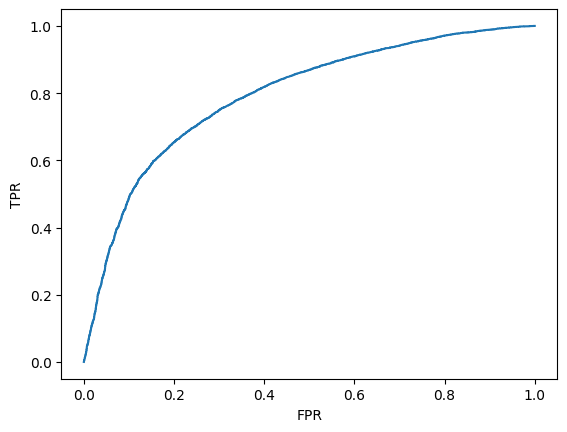

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, cat_proba[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

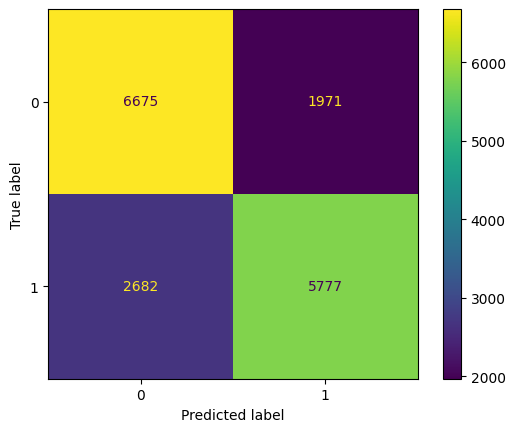

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_test, cat_results)).plot()

# Logistic regression

In [55]:
lr_model = LogisticRegression()
lr_model.fit(X_scaled_train, y_train)
lr_results = lr_model.predict(X_scaled_test)
lr_proba = lr_model.predict_proba(X_scaled_test)

In [56]:
roc_auc_score(y_test, lr_proba[:,1]), accuracy_score(y_test, lr_results), precision_score(y_test, lr_results)

(0.7894670642902122, 0.7280912014030985, 0.7528552456839309)

Text(0, 0.5, 'TPR')

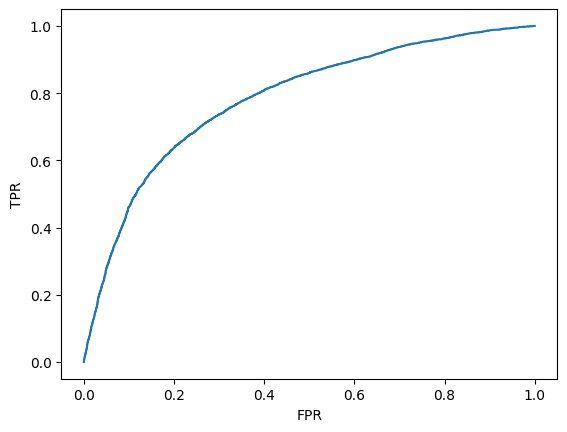

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, lr_proba[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

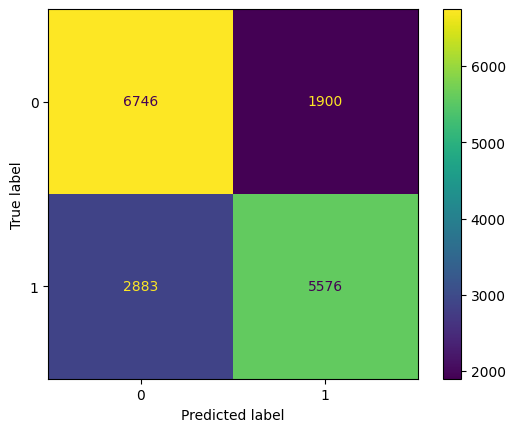

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_results)).plot()

# Small neural network

In [15]:
import torch
from torch import nn

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [17]:
def train(dataset, y, model, loss_fn, optimizer):
    model.train()
    y = torch.from_numpy(y.reshape(-1,1).astype('float32')).to(device)
    x = torch.from_numpy(dataset.astype('float32')).to(device)

    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test(dataset, y, model, loss_fn):
    model.eval()
    y = y.reshape(-1,1)
    x = torch.from_numpy(dataset.astype('float32')).to(device)

    pred = model(x).cpu().detach().numpy()
    # loss = loss_fn(pred, y).item()
    accuracy = (((pred > 0.5) == y).sum() / len(dataset))
    roc_auc = roc_auc_score(y, pred)
    return roc_auc, accuracy

In [32]:
class SmallClassificationNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        n_neurons = 12
        self.linear_stack = nn.Sequential(
            nn.Linear(12, n_neurons),
            nn.ReLU()
        )
        self.linear = nn.Linear(n_neurons, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_stack(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [19]:
nn_model = SmallClassificationNeuralNetwork().to(device)

In [20]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(nn_model.parameters(), lr=1e-4)

In [21]:
epochs = 1000
nn_model_stats = {'roc_auc': [],
                  'accuracy': [],
                #   'loss': []
                  }
for t in range(1, epochs+1):
    train(X_scaled_train.values, y_train.values, nn_model, loss_fn, optimizer)
    if t == 1 or t % 10 == 0:
        roc, acc = test(X_scaled_test.values, y_test.values, nn_model, loss_fn) # this test won't train the model. It's only for us to see that the model is training. So we don't need cross-validation here
        nn_model_stats['roc_auc'] += [roc]
        nn_model_stats['accuracy'] += [acc]
        # nn_model_stats['loss'] += [loss]
        print(f'Epoch: {t}, test stats: roc_auc={nn_model_stats['roc_auc'][-1]}, accuracy={nn_model_stats['accuracy'][-1]}')

Epoch: 1, test stats: roc_auc=0.7376136904747743, accuracy=0.5219526454253143
Epoch: 10, test stats: roc_auc=0.7488310490160905, accuracy=0.5404852382344344
Epoch: 20, test stats: roc_auc=0.7545085072006577, accuracy=0.5538731365097924
Epoch: 30, test stats: roc_auc=0.7582373628034828, accuracy=0.5636363636363636
Epoch: 40, test stats: roc_auc=0.7610229891460235, accuracy=0.5724641917567963
Epoch: 50, test stats: roc_auc=0.7632389342483564, accuracy=0.5791289096755334
Epoch: 60, test stats: roc_auc=0.7650788770162056, accuracy=0.5863197895352236
Epoch: 70, test stats: roc_auc=0.7666526394736288, accuracy=0.5921660333235896
Epoch: 80, test stats: roc_auc=0.768025230188029, accuracy=0.5983630517392575
Epoch: 90, test stats: roc_auc=0.76923518668117, accuracy=0.6047939199064601
Epoch: 100, test stats: roc_auc=0.7703042764657884, accuracy=0.6100555393159894
Epoch: 110, test stats: roc_auc=0.7712808201386246, accuracy=0.6180064308681672
Epoch: 120, test stats: roc_auc=0.7721601620224885, ac

In [26]:
epochs = 100
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-6
for t in range(1, epochs+1):
    train(X_scaled_train.values, y_train.values, nn_model, loss_fn, optimizer)
    if t == 1 or t % 10 == 0:
        roc, acc = test(X_scaled_test.values, y_test.values, nn_model, loss_fn) # this test won't train the model. It's only for us to see that the model is training. So we don't really need cross-validation here
        nn_model_stats['roc_auc'] += [roc]
        nn_model_stats['accuracy'] += [acc]
        # nn_model_stats['loss'] += [loss]
        print(f'Epoch: {t}, test stats: roc_auc={nn_model_stats['roc_auc'][-1]}, accuracy={nn_model_stats['accuracy'][-1]}')

Epoch: 1, test stats: roc_auc=0.7932987754926355, accuracy=0.7274481145863783
Epoch: 10, test stats: roc_auc=0.7932993497611878, accuracy=0.7274481145863783
Epoch: 20, test stats: roc_auc=0.7933000129046348, accuracy=0.7274481145863783
Epoch: 30, test stats: roc_auc=0.7933003957503362, accuracy=0.7274481145863783
Epoch: 40, test stats: roc_auc=0.7933010247111313, accuracy=0.7274481145863783
Epoch: 50, test stats: roc_auc=0.793301448576015, accuracy=0.7274481145863783
Epoch: 60, test stats: roc_auc=0.7933021800847659, accuracy=0.7274481145863783
Epoch: 70, test stats: roc_auc=0.7933027680263788, accuracy=0.7274481145863783
Epoch: 80, test stats: roc_auc=0.7933032944392182, accuracy=0.7274481145863783
Epoch: 90, test stats: roc_auc=0.7933039165634828, accuracy=0.7274481145863783
Epoch: 100, test stats: roc_auc=0.7933042447169412, accuracy=0.7274481145863783


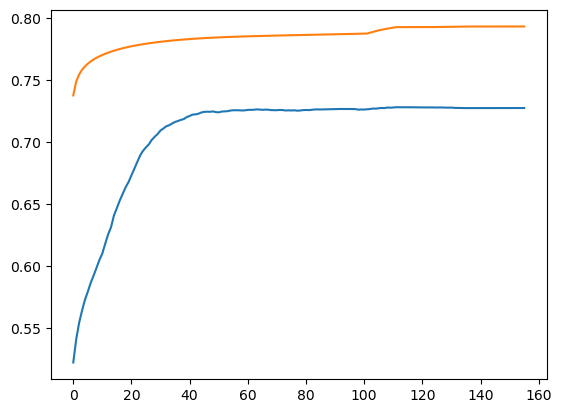

In [27]:
plt.plot(nn_model_stats['accuracy'])
plt.plot(nn_model_stats['roc_auc'])

In [28]:
nn_proba = nn_model(torch.from_numpy(X_scaled_test.values.astype('float32')).to(device)).cpu().detach().numpy()
nn_results = nn_proba >= 0.5

In [29]:
roc_auc_score(y_test, nn_proba), accuracy_score(y_test, nn_results), precision_score(y_test, nn_results)

(0.7933042447169412, 0.7274481145863783, 0.7443686446132063)

Text(0, 0.5, 'TPR')

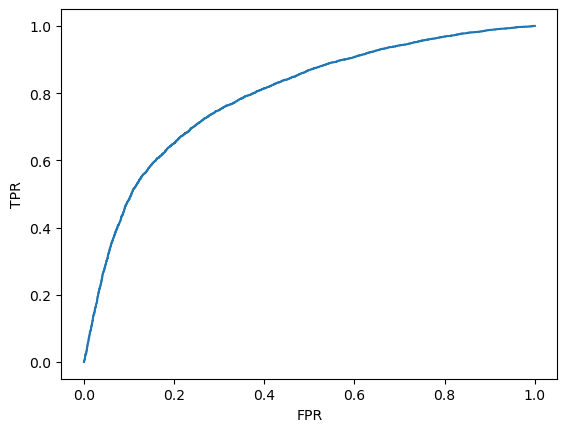

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, nn_proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

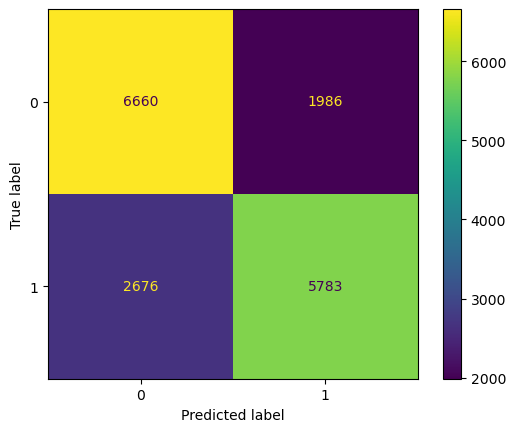

In [31]:
ConfusionMatrixDisplay(confusion_matrix(y_test, nn_results)).plot()

# Let's try to modify the neural network hyperparameters with optuna

In [18]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, trial):
        super().__init__()
        n_input = 12
        n_layers = trial.suggest_int('n_layers', 1, 3)
        layers = []

        for n in range(n_layers):
            n_neurons = trial.suggest_int(f'n_units{n}', 4, 256)
            layers.append(nn.Linear(n_input, n_neurons))
            layers.append(nn.ReLU())
            p = trial.suggest_float(f'dropout_layer{n}', 0.1, 0.5)
            layers.append(nn.Dropout(p))
            n_input = n_neurons
        
        self.linear_stack = nn.Sequential(*layers)
        self.linear = nn.Linear(n_input, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_stack(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [26]:
def objective(trial):
    loss_fn = nn.BCELoss()
    train_x, valid_x, train_y, valid_y = train_test_split(X_scaled_train, y_train)
    
    # initiate the model
    model = CustomNeuralNetwork(trial).to(device)
    # generate optimizer
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epochs = 500
    for t in range(1, epochs+1):
        train(train_x.values, train_y.values, model, loss_fn, optimizer)
        if t == 1 or t % 500 == 0:
            roc_auc, accuracy = test(valid_x.values, valid_y.values, model, loss_fn)

    torch.save(model, f'models/model{trial.number}.pth')        
    return accuracy # An objective value linked with the Trial object.

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.
joblib.dump(study, "nn_study.pkl") #save to file

[I 2024-04-06 18:21:10,551] A new study created in memory with name: no-name-4a25a3cc-ff09-4185-831d-8db27ebf4b1f
[I 2024-04-06 18:21:15,544] Trial 0 finished with value: 0.7349754462545794 and parameters: {'n_layers': 3, 'n_units0': 182, 'dropout_layer0': 0.2819747344545147, 'n_units1': 75, 'dropout_layer1': 0.27007495026157846, 'n_units2': 254, 'dropout_layer2': 0.3008995810945877, 'lr': 0.00489807278976496}. Best is trial 0 with value: 0.7349754462545794.
[I 2024-04-06 18:21:17,808] Trial 1 finished with value: 0.7374697949957129 and parameters: {'n_layers': 1, 'n_units0': 76, 'dropout_layer0': 0.3212573870658283, 'lr': 0.02861920244098378}. Best is trial 1 with value: 0.7374697949957129.
[I 2024-04-06 18:21:20,224] Trial 2 finished with value: 0.7282718840127835 and parameters: {'n_layers': 1, 'n_units0': 63, 'dropout_layer0': 0.10364433851253448, 'lr': 0.0002890491962876995}. Best is trial 1 with value: 0.7374697949957129.
[I 2024-04-06 18:21:23,576] Trial 3 finished with value: 0

['nn_study.pkl']

In [29]:
study.best_trial

FrozenTrial(number=96, state=1, values=[0.7398861953386858], datetime_start=datetime.datetime(2024, 4, 6, 18, 26, 4, 648788), datetime_complete=datetime.datetime(2024, 4, 6, 18, 26, 7, 339727), params={'n_layers': 3, 'n_units0': 174, 'dropout_layer0': 0.2201046539712601, 'n_units1': 40, 'dropout_layer1': 0.21538568799841176, 'n_units2': 4, 'dropout_layer2': 0.23597426270798072, 'lr': 0.001998198532723663}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'n_units0': IntDistribution(high=256, log=False, low=4, step=1), 'dropout_layer0': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'n_units1': IntDistribution(high=256, log=False, low=4, step=1), 'dropout_layer1': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'n_units2': IntDistribution(high=256, log=False, low=4, step=1), 'dropout_layer2': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'lr': FloatDistribution(hig

In [28]:
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

    n_layers: 3
    n_units0: 174
    dropout_layer0: 0.2201046539712601
    n_units1: 40
    dropout_layer1: 0.21538568799841176
    n_units2: 4
    dropout_layer2: 0.23597426270798072
    lr: 0.001998198532723663


In [77]:
model = torch.load('models/model96.pth').to(device)

Train the model for a little bit for whole training dataset

In [78]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001998198532723663)
epochs = 100
nn_model_stats = {'roc_auc': [],
                  'accuracy': [],
                #   'loss': []
                  }
for t in range(1, epochs+1):
    train(X_scaled_train.values, y_train.values, model, loss_fn, optimizer)
    if t == 1 or t % 10 == 0:
        roc, acc = test(X_scaled_test.values, y_test.values, model, loss_fn) # this test won't train the model. It's only for us to see that the model is training. So we don't need cross-validation here
        nn_model_stats['roc_auc'] += [roc]
        nn_model_stats['accuracy'] += [acc]
        # nn_model_stats['loss'] += [loss]
        print(f'Epoch: {t}, test stats: roc_auc={nn_model_stats['roc_auc'][-1]}, accuracy={nn_model_stats['accuracy'][-1]}')

Epoch: 1, test stats: roc_auc=0.79559956193701, accuracy=0.7261619409529377
Epoch: 10, test stats: roc_auc=0.799408432291427, accuracy=0.7338789827535809
Epoch: 20, test stats: roc_auc=0.7997180245697791, accuracy=0.7344051446945338
Epoch: 30, test stats: roc_auc=0.7995392971560006, accuracy=0.7323589593686056
Epoch: 40, test stats: roc_auc=0.799683917119703, accuracy=0.7352820812627887
Epoch: 50, test stats: roc_auc=0.7995493810383142, accuracy=0.7348143817597194
Epoch: 60, test stats: roc_auc=0.7995230125406305, accuracy=0.735223618824905
Epoch: 70, test stats: roc_auc=0.799513249975245, accuracy=0.7349313066354867
Epoch: 80, test stats: roc_auc=0.7996176643037703, accuracy=0.735399006138556
Epoch: 90, test stats: roc_auc=0.7995000759811987, accuracy=0.7345805320081847
Epoch: 100, test stats: roc_auc=0.7994604514511041, accuracy=0.7352820812627887


In [40]:
nn_proba = model(torch.from_numpy(X_scaled_test.values.astype('float32')).to(device)).cpu().detach().numpy()
nn_results = nn_proba >= 0.5

In [79]:
roc_auc_score(y_test, nn_proba), accuracy_score(y_test, nn_results), precision_score(y_test, nn_results)

(0.7991237113106047, 0.7330020461853259, 0.7728547392035895)

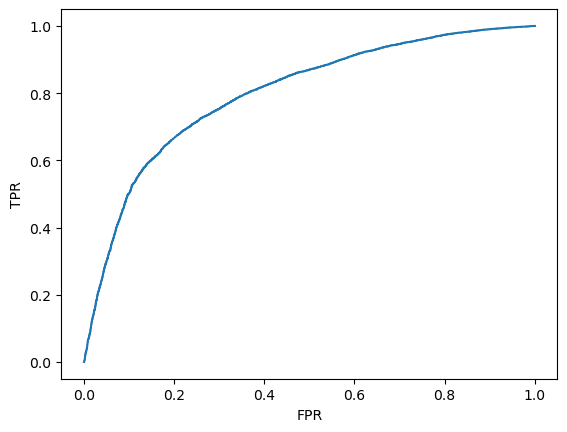

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, nn_proba)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR');

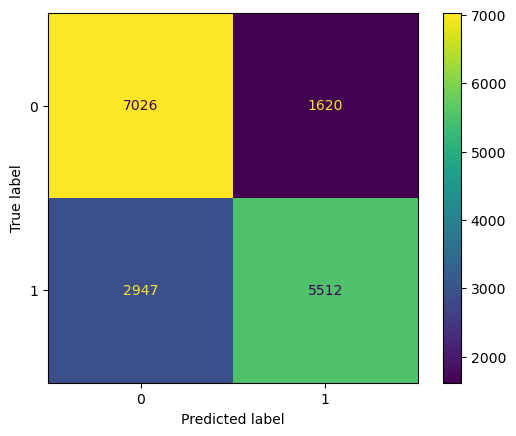

In [80]:
ConfusionMatrixDisplay(confusion_matrix(y_test, nn_results)).plot();

# Final comparison

In [62]:
comparison_df = pd.DataFrame(columns = ['model', 'roc_auc', 'accuracy', 'precision'])
comparison_df['model'] = ['logistic regression', 'XGBoost', 'Catboost', 'neural network']
comparison_df['roc_auc'] = [roc_auc_score(y_test, lr_proba[:,1]) ,roc_auc_score(y_test, xgb_proba[:,1]), roc_auc_score(y_test, cat_proba[:,1]), roc_auc_score(y_test, nn_proba)]
comparison_df['accuracy'] = [accuracy_score(y_test, lr_results), accuracy_score(y_test, xgb_results), accuracy_score(y_test, cat_results), accuracy_score(y_test, nn_results)]
comparison_df['precision'] = [precision_score(y_test, lr_results), precision_score(y_test, xgb_results), precision_score(y_test, cat_results), precision_score(y_test, nn_results)]

In [63]:
comparison_df

model   roc_auc  accuracy  precision
0  logistic regression  0.789467  0.728091   0.752855
1              XGBoost  0.799291  0.731540   0.782139
2             Catboost  0.800513  0.735984   0.754486
3       neural network  0.799124  0.733002   0.772855

This case is the binary classification problem which is considered to be rather easy. As we can see, complicated models with fine-tuned parameters have very close results to the most simple logistic regression model.

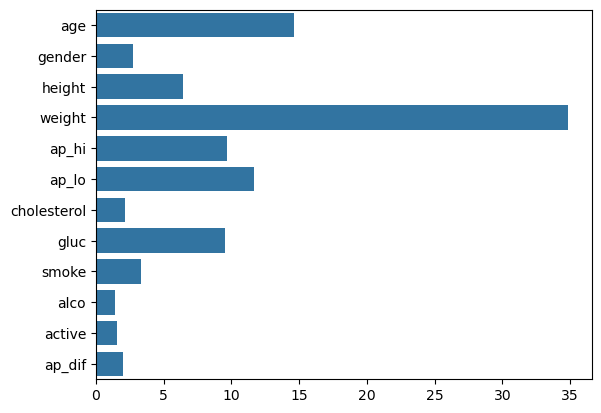

In [75]:
sns.barplot(model.feature_importances_, orient='h',).set_yticklabels(labels=X.columns);